# *OOCYTE SEMANTIC SEGMENTATION AI MODEL*
This is a notebook for creating the oocyte segmentation models in three parts: cytoplasm, zona pellucida, and oolema.  We use the TensorFlow machine-learning library to create three separate deep-learning models to identify each oocyte cell section visually.

Copyright(c) 2023 Intelon Optics.All rights reserved.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from PIL import Image
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

## Seeding
seed = 41
random.seed = seed
np.random.seed = seed
tf.seed = seed


# Preprocessing

In [ ]:
## Preparing data sets
!unzip '/content/code.zip' -d '/content/code'
!unzip '/content/ooctye-cvat-dataset.zip' -d '/content/datasets/'

In [ ]:
## Define class and the image size

# Choose image class = 'cytoplasm', 'zona-pellucida', 'oolemma'
image_class = 'cytoplasm'

# Choose image size = 128, 256, 512, 1088(original size)
image_size = 128

In [ ]:
# Define code, data, input, and save file path
code_path = f'/content/drive/Othercomputers/local/ivf-ai/'
data_path = f'/content/drive/MyDrive/ooctye-cvat-dataset/'
save_path = f'/content/drive/MyDrive/saved_model/'

In [ ]:
#### NOTE: upload CVAT extracted images and annotations and rename similary to ooctye-cvat-dataset.zip file on google colab environment and run this cell and uncomment lines for specific class based on instructions
# the ooctye-cvat-dataset.zip file contains
    # images/
    # annotations.json

if image_class == 'cytoplasm':
    !python /{code_path}/preprocess.py --annotation_path /{data_path}/annotations.json --images_path /{data_path}/images --output_path /{data_path} --included_categories "Cytoplasm" --min_pixel_in_segm 10 --roi_2_mask_flag
    !python /{code_path}/semantic_seg_data_preparation.py --annotation-path /{data_path}/train_annotations.json --image-dir /{data_path}/images --dataset-save-dir /{data_path}/cytoplasm --number-of-images 1000
elif image_class == 'zona-pellucida':
    !python /{code_path}/preprocess.py --annotation_path /{data_path}/annotations.json --images_path /{data_path}/images --output_path /{data_path} --included_categories "Zona Pellucida" --min_pixel_in_segm 10 --roi_2_mask_flag
    !python /{code_path}/semantic_seg_data_preparation.py --annotation-path /{data_path}/train_annotations.json --image-dir /{data_path}/images --dataset-save-dir /{data_path}/zona_pellucida --number-of-images 1000
elif image_class == 'oolemma':
    !python /{code_path}/preprocess.py --annotation_path /{data_path}/annotations.json --images_path /{data_path}/images --output_path /{data_path} --included_categories "Oolemma" --min_pixel_in_segm 10 --roi_2_mask_flag
    !python /{code_path}/semantic_seg_data_preparation.py --annotation-path /{data_path}/train_annotations.json --image-dir /{data_path}/images --dataset-save-dir /{data_path}/oolemma --number-of-images 1000

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Total annotations:  779
total annotation after preprocessing:  779
Total images:  79
Updated Categories:  [{'id': 1, 'name': 'Cytoplasm', 'supercategory': 'root'}]
Train annotation path:  //content/datasets//train_annotations.json
Test annotation path:  //content/datasets//test_annotations.json
{'total_org_images': 79, 'total_org_ann': 779, 'train_images': 71, 'train_ann': 110, 'test_images': 8, 'test_ann': 11}
processed data is saved inside //content/datasets/ directory
Namespace(annotation_path='//content/datasets//train_annotations.json', image_dir='//content/datasets//images', dataset_save_dir='//content/datasets//cytoplasm', number_of_images=1000)
all_dir_images:  ['20230330102439.jpg', '20230524133656.jpg', '20230524122812.jpg', '20230307104851.jpg']
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total images in annotations:  71
Total images in images directory: 

## Data Creation and Mask Visualize

In [ ]:
## Crop image to square
def resize_image(self, image: Image, length: int) -> Image:
    resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))
    # Amount of pixel to lose in total on the width of the image.
    required_loss = resized_image.size[0] - length
    # Crop the width of the image so as to keep 1088 pixels of the center part.
    resized_image = resized_image.crop(
        box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))
    # We now have a length*length pixels image.
    return resized_image

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(25, 15))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Original Image Mask')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Image')
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary Image Mask');
    ax[3].set_axis_off()

class semantic_segm_data_prep:
    def __init__(self, input_images_path, input_masks_path, height=image_size, width=image_size, output_channel=1, border=5):
        self.input_images_path = input_images_path
        self.input_masks_path = input_masks_path
        self.height = height
        self.width = width
        self.output_channel = output_channel
        self.border = border
        self.train_images = sorted(glob.glob(f'{input_images_path}/*.jpg'))
        self.train_masks = sorted(glob.glob(f'{input_masks_path}/*.jpg'))
        print(f'Total Train Images : {len(self.train_images)}\nTotal Mask Image : {len(self.train_masks)}')

    def save_data_np(self, output_dir=''):
        X = np.zeros((len(self.train_images), self.height, self.width, 3), dtype=np.float32)
        y = np.zeros((len(self.train_masks), self.height, self.width, self.output_channel), dtype=np.float32)

        for n, (img, mimg) in tqdm(enumerate(zip(self.train_images, self.train_masks))):
            # print(n, img, mimg)
            # Load images
            img = load_img(img)
            img = resize_image(self, img, self.height)
            x_img = img_to_array(img)
            x_img = resize(x_img, (self.height, self.width, 3), mode = 'constant', preserve_range = True)

            # # Load masks
            mask_img = load_img(mimg, color_mode = "grayscale")
            mask_img = resize_image(self, mask_img, self.height)
            mask = img_to_array(mask_img)
            mask = resize(mask, (self.height, self.width, self.output_channel), mode = 'constant', preserve_range = True)

            # # Save images
            X[n] = x_img/255.0
            y[n] = mask/255.0
            # Save the files in Numpy array for reusability
            np.save(f'{output_dir}/X_{self.height}x{self.width}.npy', X)
            np.save(f'{output_dir}/y_{self.height}x{self.width}.npy', y)
        print(X.shape, y.shape)

    def load_saved_np(self, X_path, y_path):
        # load images and mask from numpy array saved files
        X = np.load(X_path)
        y = np.load(y_path)
        print(X.shape, y.shape)
        return X, y

    def split_ann(self, X, y):
        # Split train and valid
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    def plot_img_mask(self, X, y, number_of_samples, id=None):
        for i in range(number_of_samples):
            # Visualize any randome image along with the mask
            if id != None:
                ix = id
            else:
                ix = random.randint(0, len(X) - 1)
            has_mask = y[ix].max() > 0 # salt indicator

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

            ax1.imshow(X[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
            if has_mask: # if salt
                # draw a boundary(contour) in the original image separating salt and non-salt areas
                ax1.contour(y[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
            ax1.set_title('Original Image')
            ax1.set_axis_off()
            ax2.imshow(y[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
            ax2.set_title('Mask Image')
            ax2.set_axis_off()
            plt.show()

Total Train Images : 71
Total Mask Image : 71


0it [00:00, ?it/s]

(71, 128, 128, 3) (71, 128, 128, 1)
(71, 128, 128, 3) (71, 128, 128, 1)
Dataset split:  (63, 128, 128, 3) (63, 128, 128, 1) (8, 128, 128, 3) (8, 128, 128, 1)


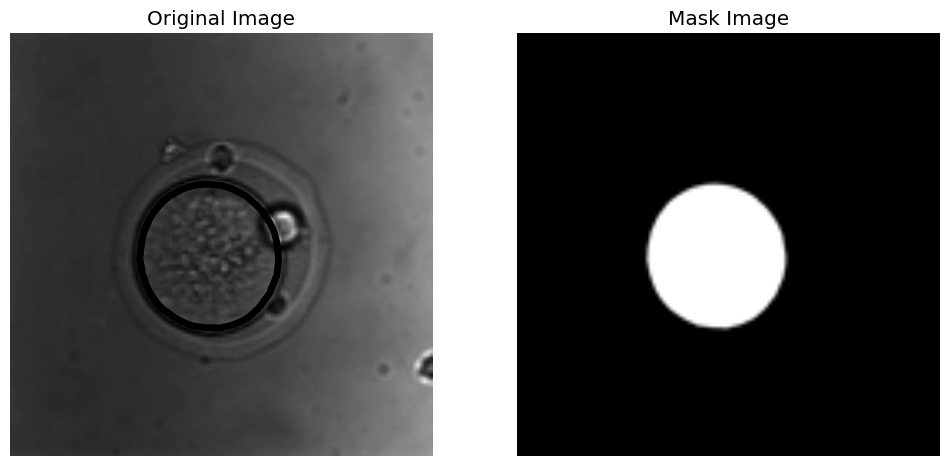

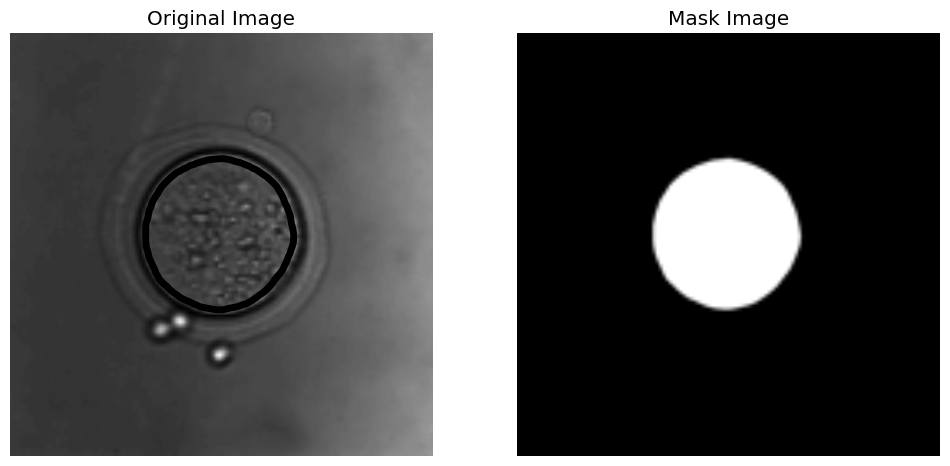

(63, 63)

In [ ]:
## Training images

# set height(h) and width(w) of the image
h = image_size
w = image_size

input_path = f'/content/drive/MyDrive/ooctye-cvat-dataset/{image_class}'
output_path = f'/content/drive/MyDrive/ooctye-cvat-dataset/{image_class}'
ss_preprocess = semantic_segm_data_prep(input_images_path=f'/{input_path}/images',
                                        input_masks_path=f'/{input_path}/masks',
                                        height=h,
                                        width=w,
                                        output_channel=1)
# ss_preprocess.save_data_np(output_dir=f'/{output_path}')
X, y = ss_preprocess.load_saved_np(X_path=f'/{output_path}/X_{h}x{w}.npy',
                                   y_path=f'/{output_path}/y_{h}x{w}.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('Dataset split: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ss_preprocess.plot_img_mask(X_train, y_train, number_of_samples=2)
len(X_train), len(y_train)

# Training

In [ ]:
#### NOTE: Change parameters here or uncomment the code to run
# You can set the model name--model-name "vggunet" --> vggnet or unet
training_model = "vggunet"
# You can set epochs to any number: --epochs
epochs = 20

if image_class == 'cytoplasm':
   !python /{code_path}/trainer.py --images-npy-path /{data_path}/cytoplasm/X_{image_size}x{image_size}.npy --masks-npy-path /{data_path}/cytoplasm/y_{image_size}x{image_size}.npy --model-name {training_model} --input-height {image_size} --input-width {image_size} --min-lr 0.0001 --batch-size 2 --epochs {epochs} --saved-model-path /{save_path}/cytoplasm --pretrained-model-path /{save_path}/cytoplasm/model-vggunet.h5
elif image_class == 'zona-pellucida':
   !python /{code_path}/trainer.py --images-npy-path /{data_path}/zona_pellucida/X_{image_size}x{image_size}.npy --masks-npy-path /{data_path}/zona_pellucida/y_{image_size}x{image_size}.npy --model-name {training_model} --input-height {image_size} --input-width {image_size} --min-lr 0.0001 --batch-size 2 --epochs {epochs} --saved-model-path /{save_path}/zona_pellucida --pretrained-model-path /{save_path}/zona_pellucida/model-vggunet.h5
elif image_class == 'oolemma':
    !python /{code_path}/trainer.py --images-npy-path /{data_path}/oolemma/X_{image_size}x{image_size}.npy --masks-npy-path /{data_path}/oolemma/y_{image_size}x{image_size}.npy --model-name {training_model} --input-height {image_size} --input-width {}image_size --min-lr 0.0001 --batch-size 2 --epochs {epochs} --saved-model-path /{save_path}/oolemma --pretrained-model-path /{save_path}/oolemma/model-vggunet.h5


2023-12-15 07:56:50.622067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 07:56:50.622110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 07:56:50.623728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 07:56:51.666068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Full Dataset Shapes:  (71, 128, 128, 3) (71, 128, 128, 1)
Dataset split:  (63, 128, 128, 3) (63, 128, 128, 1) (8, 128, 128, 3) (8, 128, 128, 1)
Train dataset size:  63
Test dataset size:  8
Loading Pretrained Model
2023-12-15 07:56:53.757052

## Visualize Loss & Accuracy Curves

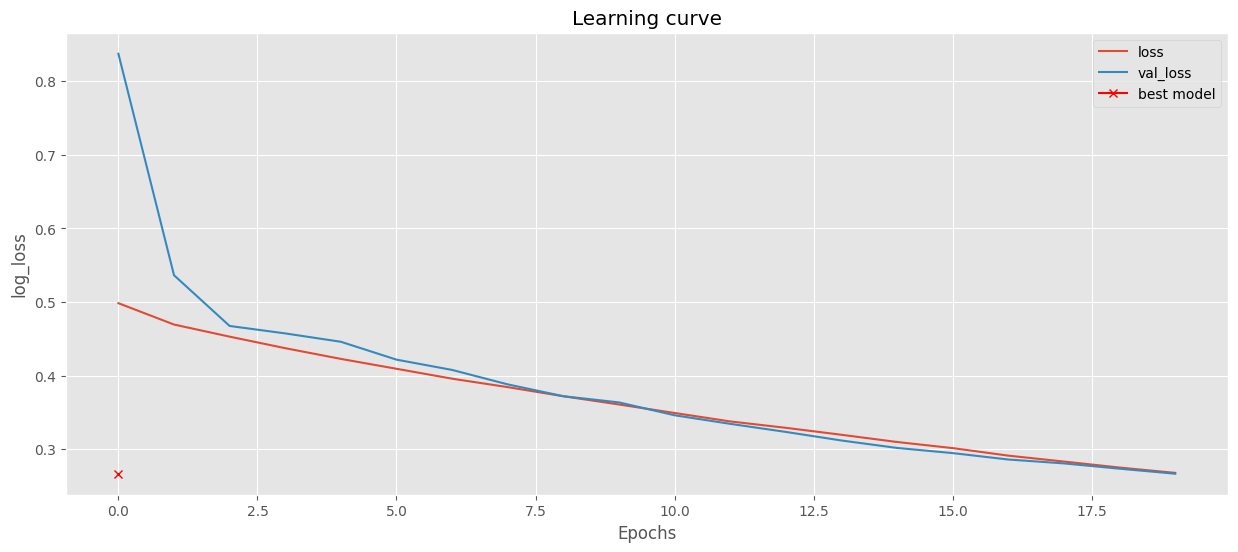

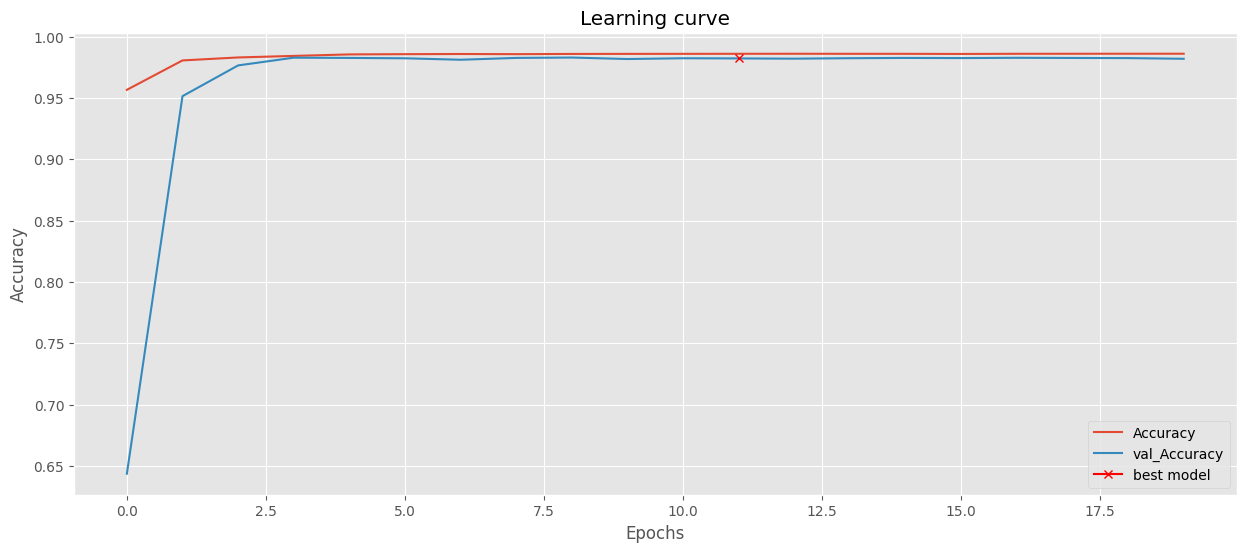

In [ ]:
#### NOTE: DEFINE train_csv_file_path

if image_class == 'cytoplasm':
    train_csv_file_path = '/content/drive/MyDrive/saved_model/cytoplasm/data_vggunet.csv'
elif image_class == 'zona-pellucida':
    train_csv_file_path = '/content/drive/MyDrive/saved_model/zona_pellucida/data_vggunet.csv'
elif image_class == 'oolemma':
    train_csv_file_path = '/content/drive/MyDrive/saved_model/oolemma/data_vggunet.csv'

df_result = pd.read_csv(train_csv_file_path)
df_result.sort_values('val_loss', ascending = True, inplace = True)

# Plot curves
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(df_result["loss"], label="loss")
plt.plot(df_result["val_loss"], label="val_loss")
plt.plot(np.argmin(df_result["val_loss"]), np.min(df_result["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(df_result["accuracy"], label="Accuracy")
plt.plot(df_result["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(df_result["val_accuracy"]), np.max(df_result["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Evaluation

In [ ]:
%cd /content/drive/Othercomputers/local/ivf-ai

#### NOTE: Define model path here

if image_class == 'cytoplasm':
    model_path = f'/{save_path}/cytoplasm/model-vggunet.h5'
elif image_class == 'zona-pellucida':
    model_path = f'/{save_path}/zona_pellucida/model-vggunet.h5'
elif image_class == 'oolemma':
    model_path = f'/{save_path}/oolemma/model-vggunet.h5'

from semantic_segm_models import semantic_segm_models
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

model_name = training_model
ss_models = semantic_segm_models(input_height=image_size, input_width=image_size)
model = ss_models.load_model(model_name=model_name)
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
model.load_weights(model_path)
eval_matrics = model.evaluate(X_test, y_test, verbose=1)

# Prediction on y_test
y_pred = model.predict(X_test)

# Reshape groundtruth and predictions
y_test_reshaped = y_test.reshape(-1)
y_pred_reshaped = y_pred.reshape(-1)

# # Threshold the probability scores (e.g., 0.5 threshold)
y_test_binary = (y_test_reshaped > 0.1).astype(int)
y_pred_binary = (y_pred_reshaped > 0.5).astype(int)

# Calculate the mAP
mAP = average_precision_score(y_test_binary, y_pred_binary)
print('mAP:', mAP)
print('Accuracy: ', eval_matrics[1])
print('sensitivity_at_specificity: ', eval_matrics[3])
print('specificity_at_sensitivity: ', eval_matrics[4])

/content/drive/Othercomputers/local/ivf-ai
1/1 [==============================] - 1s 535ms/step
mAP: 0.9432000188466916
Accuracy:  0.981964111328125
sensitivity_at_specificity:  0.9921606183052063
specificity_at_sensitivity:  0.9995885491371155


In [ ]:

# Predict on train, val and test
# preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 25ms/step


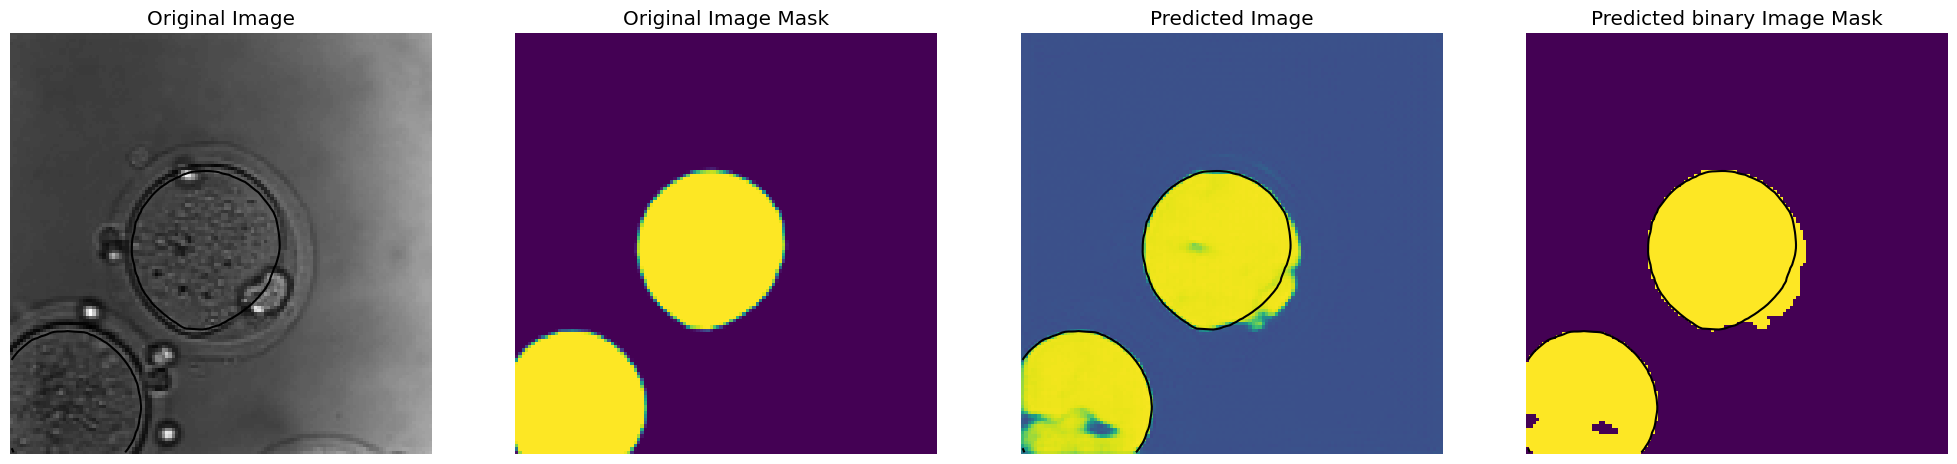

In [ ]:
# plot original image, labelled image, predicted image, threshold image
for ix in random.sample(range(0, 10), 1):
    plot_sample(X_test, y_test, preds_val, preds_val_t, ix=3)

# Predictions on unseen data

In [ ]:
from inference import semantic_segm_inference
import matplotlib.pyplot as plt
import glob, json
import cv2, random
from oocyte_visualizer import draw_circles_intersection2, is_inner_polygon, is_circular_shape
from shapely.geometry import Polygon
import numpy as np
from config import colors

def draw_predictions(image, pred_dict, clas=image_class, color=None):
    circles_list = []
    for poly, mask in zip(pred_dict['pred_polygons'], pred_dict['pred_polygons']):
        if is_circular_shape(poly, threshold=0.95) and clas != 'cytoplasm':
            if len(circles_list) > 0:
                for circle in circles_list:
                    if is_inner_polygon(circle, poly) and not np.all(poly == circles_list):
                        draw_circles_intersection2(circle, poly, image, color=color, plot_flag=False)
                    elif is_inner_polygon(poly, circle) and not np.all(poly == circles_list):
                        draw_circles_intersection2(poly, circle, image, color=color, plot_flag=False)
                else:
                    circles_list.append(poly)
            else:
                circles_list.append(poly)
        else:
            cv2.polylines(image, [np.array(poly).reshape((-1, 1, 2))], True, color, 4)
            cv2.fillPoly(image, [np.array(poly).reshape((-1, 1, 2))], color)
    return image

# def oocyte_prediction(test_annotations, images_path, cytoplasm_model_path, zona_pellucida_model_path, oolemma_model_path, number_of_images, cytoplasm_threshold=0.5, zona_pellucida_threshold=0.5, oolemma_threshold=0.3):
def oocyte_prediction(test_annotations, images_path, model_path, number_of_images, threshold=0.5):

    # LOAD MODELS
    predictor = semantic_segm_inference(model_name=training_model, input_size=image_size, model_path=model_path)
    # cytoplasm_predictor = semantic_segm_inference(model_name='vggunet', input_size=image_size, model_path=cytoplasm_model_path)
    # zp_predictor = semantic_segm_inference(model_name='vggunet', input_size=image_size, model_path=zona_pellucida_model_path)
    # oolemma_predictor = semantic_segm_inference(model_name='vggunet', input_size=image_size, model_path=oolemma_model_path)


    with open(test_annotations, 'r') as fr:
        data = json.load(fr)

    for img_path in [images_path + '/' + img['file_name'] for img in data['images']][0:number_of_images]:
        image = cv2.imread(img_path)

        plt.imshow(image)
        # plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pred_image = image.copy()

        random_color = (random.randint(0,255),random.randint(0,255), random.randint(0,255))
        # print(random_color)
        color = random_color #colors[3]

        pred_dict = predictor.inference(input_object=image, threshold=threshold)
        pred_image = draw_predictions(pred_image, pred_dict, clas=image_class, color=colors[1])

        # # img = plt.imread(img_path)
        # cytoplasm_pred_dict = cytoplasm_predictor.inference(input_object=image, threshold=cytoplasm_threshold)
        # pred_image = draw_predictions(pred_image, cytoplasm_pred_dict, clas='cytoplasm', color=colors[0])

        # zp_pred_dict = zo_predictor.inference(input_object=image, threshold=zona_pellucida_threshold)
        # pred_image = draw_predictions(pred_image, zp_pred_dict, clas='zona-pellucida', color=colors[1])

        # oolemma_pred_dict = oolemma_predictor.inference(input_object=image, threshold=oolemma_threshold)
        # pred_image = draw_predictions(pred_image, oolemma_pred_dict, clas='oolemma', color=colors[2])
        # oolemma_predictor.draw_predictions()

        plt.imshow(pred_image)
        # plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

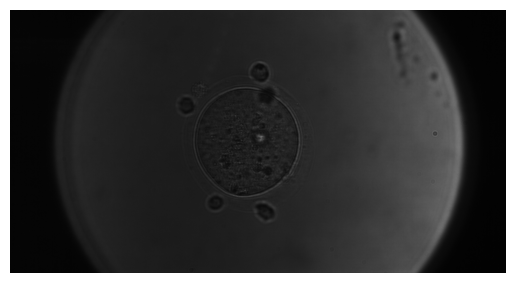

1/1 [==============================] - 1s 520ms/step


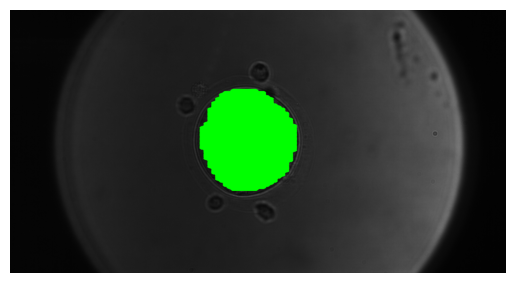

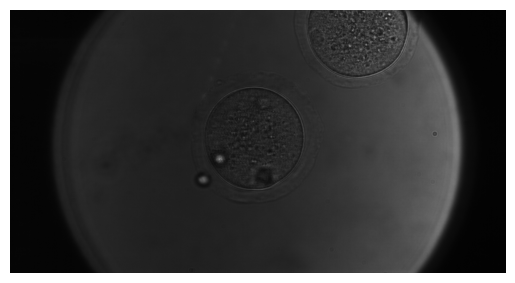

1/1 [==============================] - 0s 23ms/step


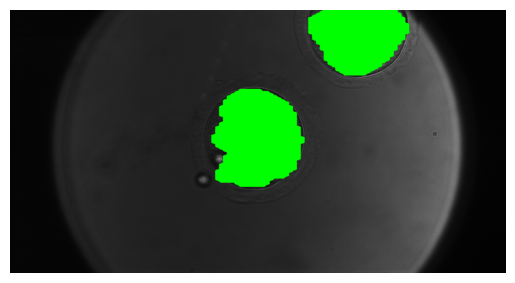

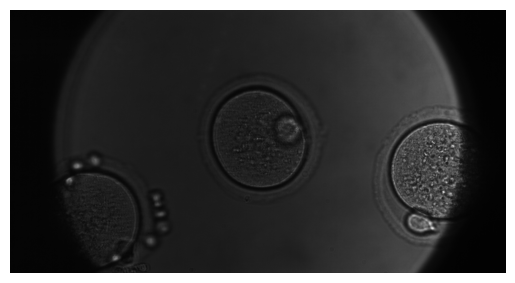

1/1 [==============================] - 0s 23ms/step


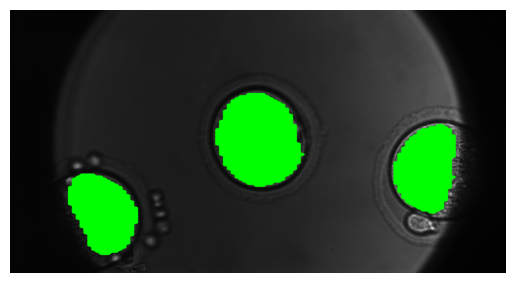

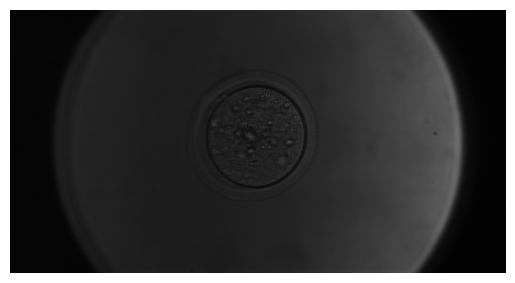

1/1 [==============================] - 0s 23ms/step


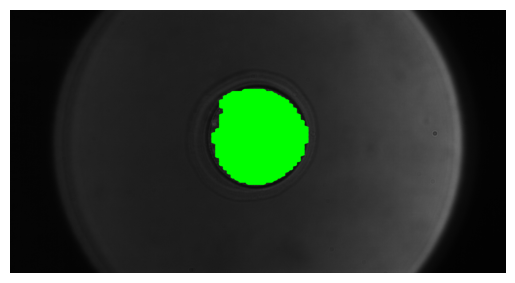

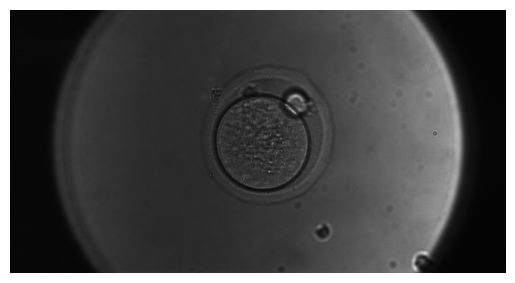

1/1 [==============================] - 0s 22ms/step


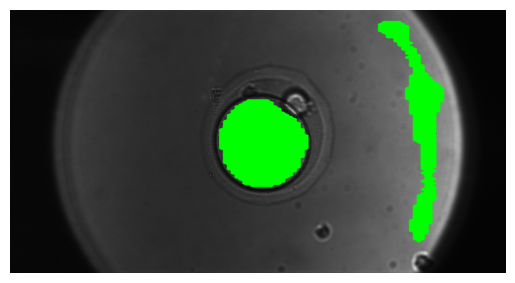

In [ ]:

oocyte_prediction(test_annotations='/content/drive/MyDrive/ooctye-cvat-dataset/test_annotations.json',
                  images_path='/content/drive/MyDrive/ooctye-cvat-dataset/images',
                  model_path=f'/content/drive/MyDrive/saved_model/{image_class}/model-vggunet.h5',
                  number_of_images=5)

In [ ]:
#### NOTE define test annotations path, images path, all models path

oocyte_prediction(test_annotations='/content/drive/MyDrive/ooctye-cvat-dataset/test_annotations.json',
                  images_path='/content/drive/MyDrive/ooctye-cvat-dataset/images',
                  cytoplasm_model_path='/content/drive/MyDrive/saved_model/cytoplasm/model-vggunet.h5',
                  zona_pellucida_model_path='/content/drive/MyDrive/saved_model/zona_pellucida/model-vggunet.h5',
                  oolemma_model_path='/content/drive/MyDrive/saved_model/oolemma/model-vggunet.h5',
                  number_of_images=2)

In [ ]:
#### NOTE define test annotations path, images path, all models path

oocyte_prediction(test_annotations='/content/drive/MyDrive/ooctye-cvat-dataset/test_annotations.json',
                  images_path='/content/drive/MyDrive/ooctye-cvat-dataset/images',
                  cytoplasm_model_path='/content/drive/MyDrive/saved_model/cytoplasm/model-vggunet.h5',
                  zona_pellucida_model_path='/content/drive/MyDrive/saved_model/zona_pellucida/model-vggunet.h5',
                  oolemma_model_path='/content/drive/MyDrive/saved_model/oolemma/model-vggunet.h5',
                  number_of_images=2)

# New Inference Code --> 19-12-2023

In [ ]:
!unzip /content/code-20-12-2023-20231219T090407Z-001.zip -d /content/

In [ ]:
%cd /content/code-20-12-2023

1/1 [==============================] - 1s 500ms/step


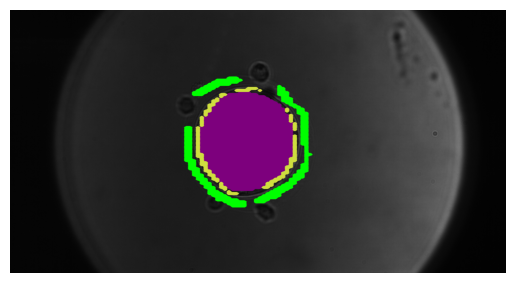

CPU times: user 15.1 s, sys: 2.1 s, total: 17.2 s
Wall time: 24.4 s


dict_keys(['Cytoplasm', 'Oolemma', 'Zona Pellucida'])

In [3]:
%%time
from postprocessing import oocyte_single_prediction, visualize_mask
import matplotlib.pyplot as plt

# Define image path
images_path = f"/content/drive/MyDrive/dataset/images/20230307102527.jpg"

# Define Trained models path
cytoplasm_model_path=f'/content/drive/MyDrive/saved_model/cytoplasm/model-vggunet.h5'
zona_pellucida_model_path=f'/content/drive/MyDrive/ssaved_model/zona_pellucida/model-vggunet.h5'
oolemma_model_path=f'/content/drive/MyDrive/saved_model/oolemma/model-vggunet.h5'

# Modify the threshold if needed
cytoplasm_threshold=0.5
zona_pellucida_threshold=0.5
oolemma_threshold=0.3

# Change this value to False if you want to return the Boundries only
fill_mask = True

preds = oocyte_single_prediction(images_path, fill_mask, cytoplasm_model_path, zona_pellucida_model_path, oolemma_model_path, cytoplasm_threshold=0.5, zona_pellucida_threshold=0.5, oolemma_threshold=0.3)
preds.keys()

(1088, 2048) 3724


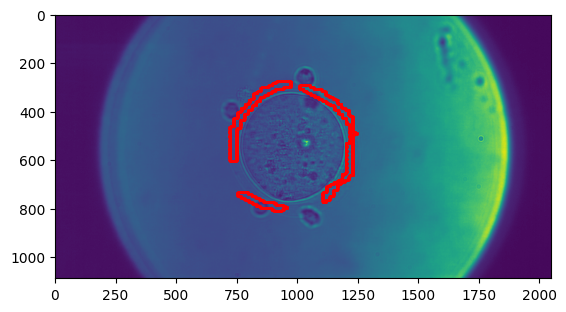

In [4]:
##### PLOT FULL MASK ON THE SAME IMAGE AFTER FLIP AND SORTING

# CHANGE Cytoplsam -> Oolemma or Zona Pellucida
visualize_mask(images_path, preds['Zona Pellucida'])

### Bulk Prediction

1/1 [==============================] - 1s 713ms/step


1/1 [==============================] - 1s 694ms/step


1/1 [==============================] - 1s 719ms/step


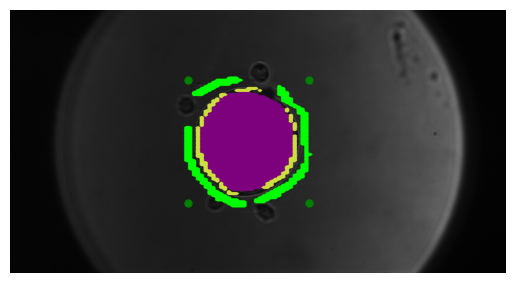

1/1 [==============================] - 0s 19ms/step


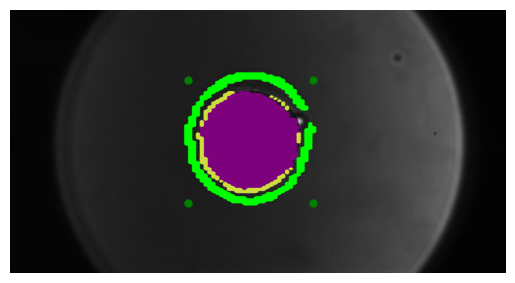

1/1 [==============================] - 0s 20ms/step


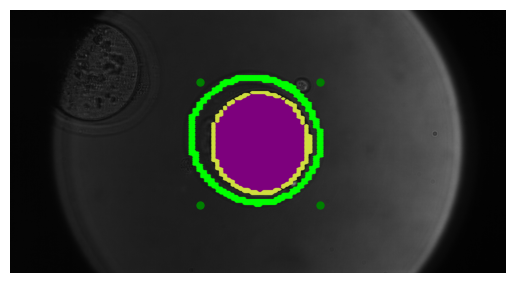

1/1 [==============================] - 0s 24ms/step


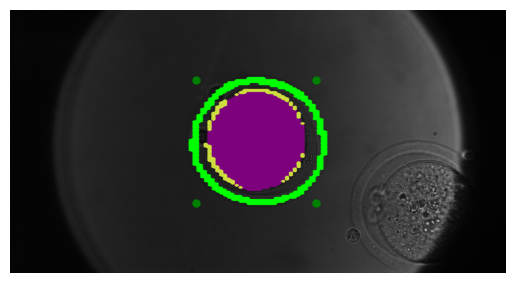

1/1 [==============================] - 0s 33ms/step


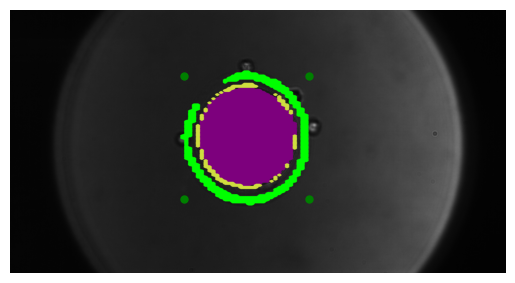

1/1 [==============================] - 0s 31ms/step


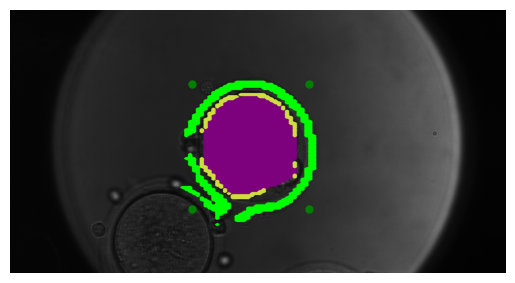

1/1 [==============================] - 0s 33ms/step


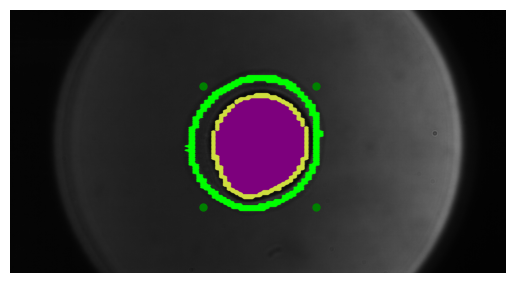

1/1 [==============================] - 0s 23ms/step


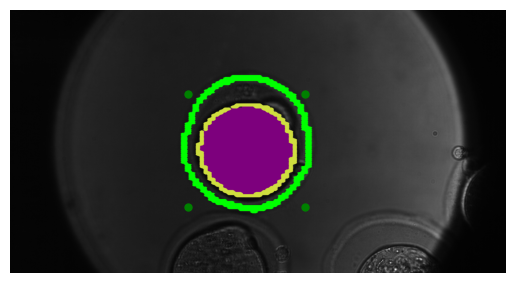

1/1 [==============================] - 0s 21ms/step


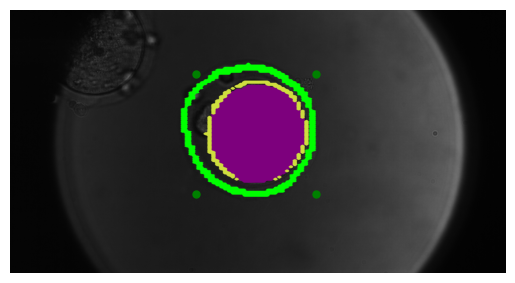

1/1 [==============================] - 0s 26ms/step


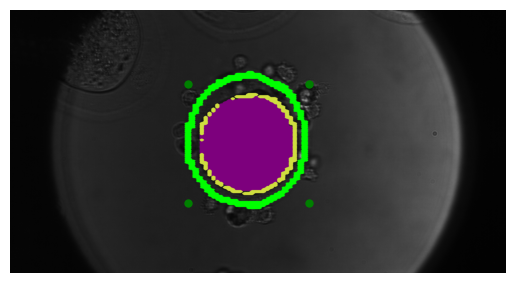

1/1 [==============================] - 0s 41ms/step


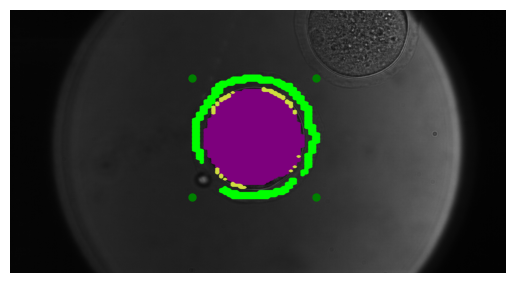

1/1 [==============================] - 0s 21ms/step


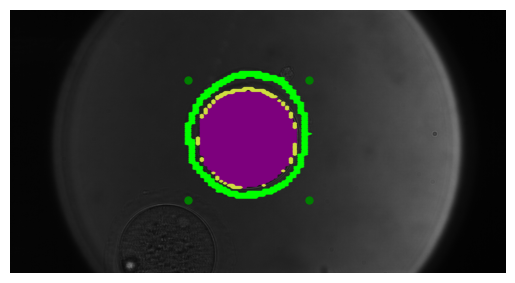

1/1 [==============================] - 0s 21ms/step


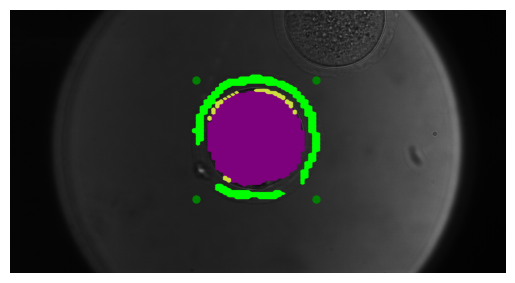

1/1 [==============================] - 0s 22ms/step


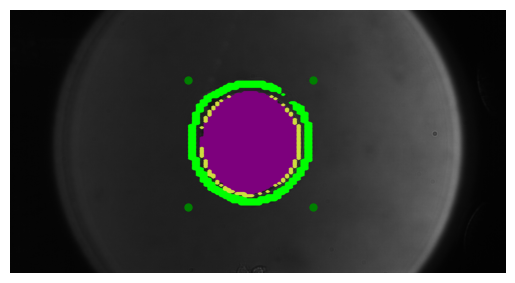

1/1 [==============================] - 0s 34ms/step


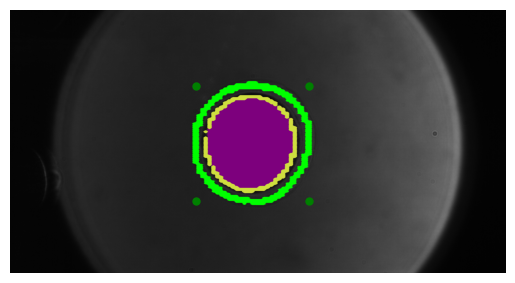

In [6]:
from postprocessing import oocyte_prediction

#### NOTE define test annotations path, images path, all models path
root = "/content/drive/MyDrive/"
dataset_path = f"{root}/dataset"
# root = "/content/datasets"
# dataset_path = "datasets"
oocyte_prediction(test_annotations=f'{dataset_path}/annotations.json',
                  images_path=f'{dataset_path}/images',
                  cytoplasm_model_path=f'{root}/saved_model/cytoplasm/model-vggunet.h5',
                  zona_pellucida_model_path=f'{root}/saved_model/zona_pellucida/model-vggunet.h5',
                  oolemma_model_path=f'{root}/saved_model/oolemma/model-vggunet.h5',
                  number_of_images=15)